# Sales_Prediction (Time Series)

In [9]:
from google.colab import files
uploaded = files.upload()

Saving sales_train_v2.csv to sales_train_v2 (1).csv


In [0]:
# Basic packages
import numpy as np 
import pandas as pd 
import random as rd 
import datetime 
from itertools import product
from tqdm import tqdm_notebook


# Viz
import matplotlib.pyplot as plt 
import seaborn as sns 


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [0]:
df = pd.read_csv('sales_train_v2.csv')
test = pd.read_csv('test.csv')

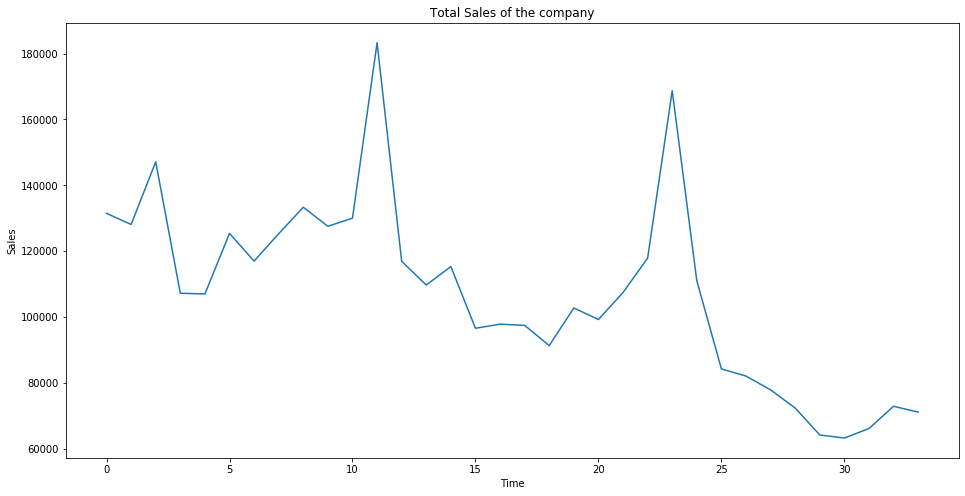

In [14]:
ts=df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);


Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

- Additive time series:
Value = Base Level + Trend + Seasonality + Error

- Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

<Figure size 1152x864 with 0 Axes>

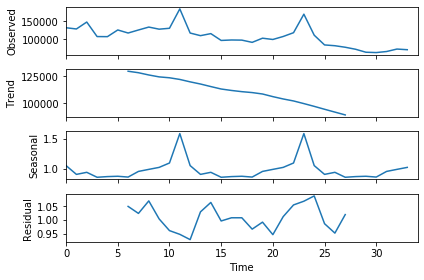

In [0]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()

<Figure size 1152x864 with 0 Axes>

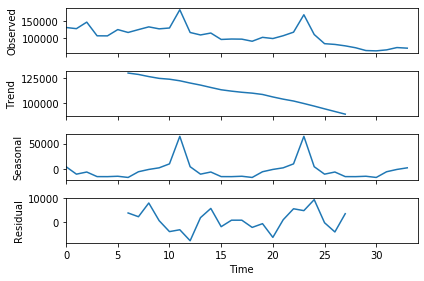

In [0]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()

In [17]:
# Stationarity tests
# if the dataset is stationary, it is easier to model it
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test: \n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test: 

Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Currently, the p-value is 0.14 which is quite large and not enough to say the data is stationary.

In [0]:
# remove trend / seasonality from the dataset
# define a function to substract the pre-selected interval
# to remove trend: set interval = 1
# to remove seasonality: set interval = 12

from pandas import Series as Series

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [19]:
detrended = difference(ts, 1)
de_season = difference(ts, 12)
print(test_stationarity(detrended))
print(test_stationarity(de_season))

Results of Dickey-Fuller Test: 

Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
None


Now the p-value is small enough to be stationary after we detrend the dataset. 

[]

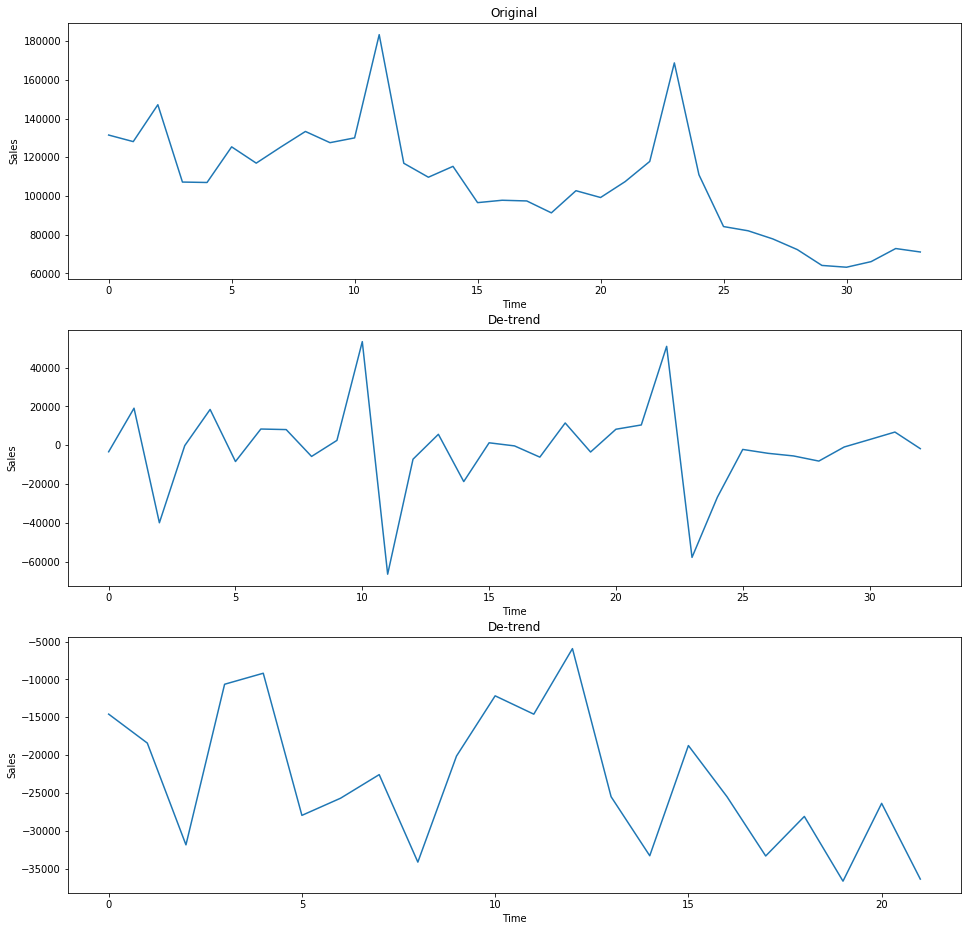

In [21]:
# comparision of original dataset and the detrend dataset
ts=df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(detrended)
plt.plot()

plt.subplot(313)
plt.title('De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(de_season)
plt.plot()

## Time Series Analysis

Three types of time series model
- MA - Next value in the series is a function of the average of the previous n number of values 
- AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values 
- ARMA - a mixture of both.

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

        return

In [24]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(de_season.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


## Mean Average Percentage Error (MAPE)

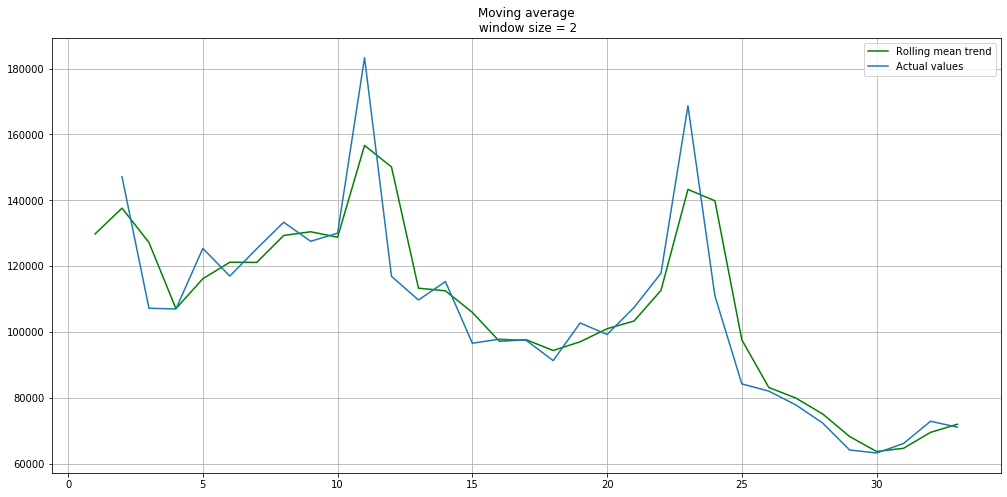

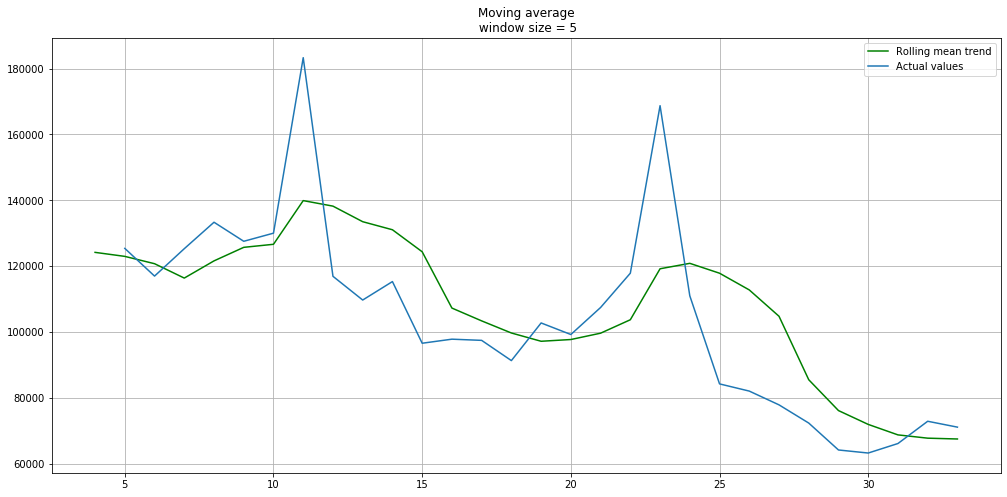

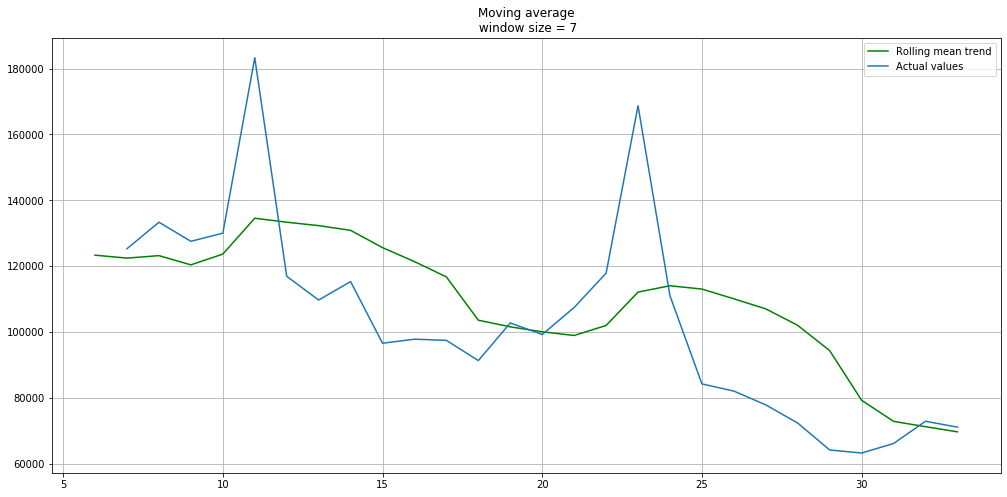

In [25]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 2 month
plot_moving_average(ts, 2)

#Smooth by the previous 5 month
plot_moving_average(ts, 5)

#Smooth by previous 7 month
plot_moving_average(ts, 7)

## Exponential Smoothing

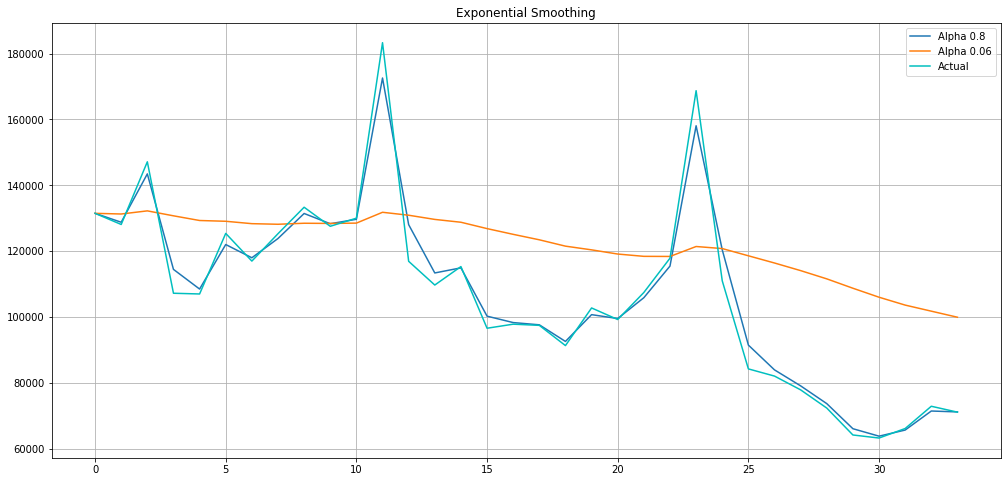

In [29]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(ts, [0.8, 0.06])

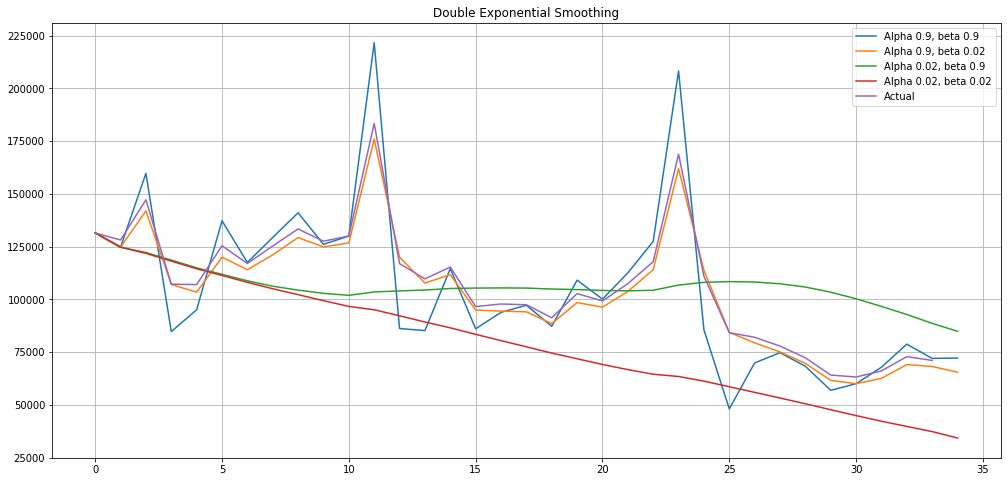

In [31]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(ts, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Make Prediction with Prophet from FB

In [0]:
# adding the dates 
ts=df.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts_train = ts[:31] # leave the last three for validation
ts_validation = ts[31:] # for validation

In [45]:
# make predictions using Facebook open library Prophet
from fbprophet import Prophet
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)

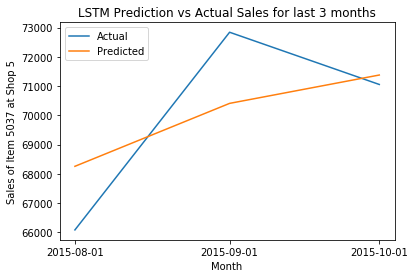

In [64]:
fig, ax = plt.subplots()
ax.plot(ts_validation['index'], ts_validation['item_cnt_day'], label='Actual')
ax.plot(forecast['ds'][31:34], forecast['yhat'][31:34], label='Predicted')
plt.title('LSTM Prediction vs Actual Sales for last 3 months')
plt.xlabel('Month')
plt.xticks(ts_validation['index'])
plt.ylabel('Sales of Item 5037 at Shop 5')
ax.legend()
plt.show()

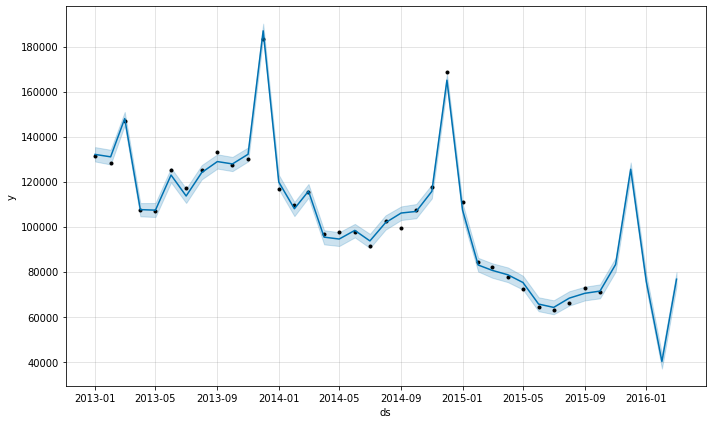

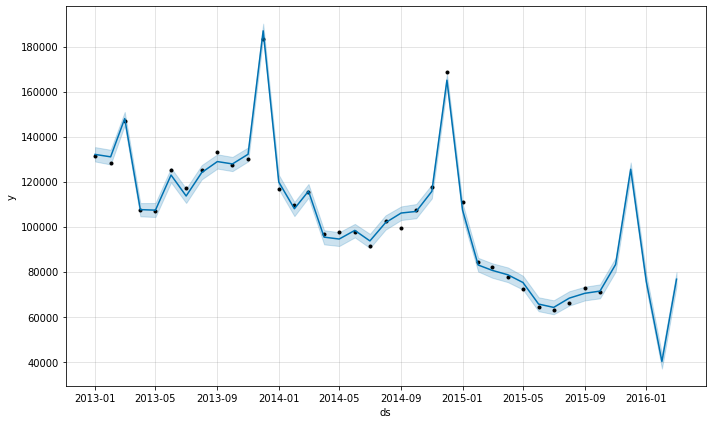

In [51]:
model.plot(forecast)